In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('loan.csv')

In [3]:
df.replace("NaN", np.nan, inplace = True)

## catching missing data problem 
1. Removing all columns with no value in it
2. Capturing columns and removing with less than 10% of data
3. For features with NAs - figure out process to fill

In [4]:
columns_to_remove = df.loc[:,df.count()/df.shape[0] < 0.1].columns.tolist()

In [5]:
df1 = df[[col for col in df.columns if col not in columns_to_remove]]

## removing all columns with single unique value

In [6]:
df1.drop(df1.loc[:,df1.nunique() == 1].columns.tolist(), axis=1,inplace = True)

## post removing empty columns - most NAs are in - 
1. mths_since_last_delinq - this is months against last criminal activity - considering it to be a large positive number for empty - assuming no criminal record
2. desc - this is loan description - removing it fow now since this is free string field and cannot be used (without NLP)
3. emp_title - filling it with empty string - since we dont know anything about it
4. emp_legth - leaving it as NA only

<Axes: title={'center': 'Distribution of mths_since_last_delinq value'}, ylabel='Frequency'>

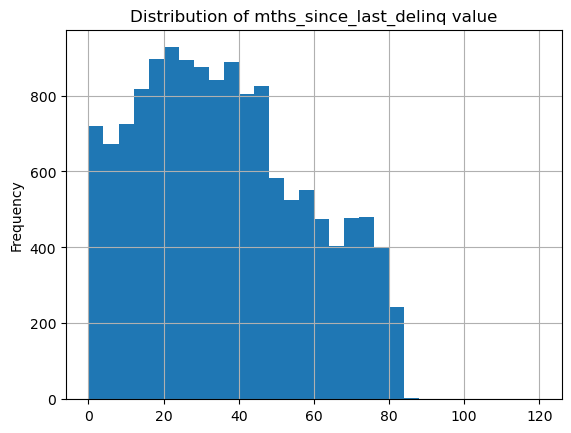

In [7]:
## identofying value to fill in 'mths_since_last_delinq' column
df1['mths_since_last_delinq'].plot(kind = 'hist', grid = True, bins = 30, title = 'Distribution of mths_since_last_delinq value')

In [8]:
## based on the plot, safe to say we can take 130D to fill NAs
df1.mths_since_last_delinq.fillna(130, inplace = True)

In [9]:
df1.drop('desc', axis=1, inplace = True)

In [10]:
df1.emp_title.fillna('', inplace = True)

## checking data type of all features

In [11]:
print (f'''features of object data type - {df1.select_dtypes('object').shape[1]}''')
print (f'''features of int data type - {df1.select_dtypes('int').shape[1]}''')
print (f'''features of float data type - {df1.select_dtypes('float').shape[1]}''')

features of object data type - 19
features of int data type - 10
features of float data type - 16


In [12]:
## we can leave int and float type features and check usability of object datatype features
object_df = df1.select_dtypes('object')

## object columns can be converted to int/float

In [13]:
object_df['term'] = pd.to_numeric(object_df['term'].str.replace("months",""))
object_df['int_rate'] = pd.to_numeric(object_df.int_rate.str.replace("%",""))
object_df['revol_util'] = pd.to_numeric(object_df.revol_util.str.replace("%",""))


## converting emp_length to numeric - by making <1 to 0.5 and >10 to 11
object_df['emp_length'] = pd.to_numeric(object_df.emp_length.str.replace("years", "").str.replace("< 1 year", "0.5").str.replace("10+", "11").str.replace("year", ""))

In [14]:
## have missing values - in datetime fields - filling these with issue_d
object_df.loc[object_df.last_pymnt_d.isnull(), 'last_pymnt_d'] = object_df.loc[object_df.last_pymnt_d.isnull(), 'issue_d']
object_df.loc[object_df.last_credit_pull_d.isnull(), 'last_credit_pull_d'] = object_df.loc[object_df.last_credit_pull_d.isnull(), 'issue_d']

In [15]:
## converting issue_d,earliest_cr_line,last_pymnt_d,last_credit_pull_d to datetime
object_df['issue_d'] = object_df['issue_d'].apply(lambda x: datetime.strptime(x, "%b-%y"))
object_df['earliest_cr_line'] = object_df['earliest_cr_line'].apply(lambda x: datetime.strptime(x, "%b-%y"))
object_df['last_pymnt_d'] = object_df['last_pymnt_d'].apply(lambda x: datetime.strptime(x, "%b-%y"))
object_df['last_credit_pull_d'] = object_df['last_credit_pull_d'].apply(lambda x: datetime.strptime(x, "%b-%y"))

## removing few columns and reordering

In [16]:
object_df.columns

Index(['term', 'int_rate', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'url', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line',
       'revol_util', 'last_pymnt_d', 'last_credit_pull_d'],
      dtype='object')

In [17]:
object_df = object_df.drop(['url','zip_code'], axis=1)[['emp_title','verification_status','home_ownership','purpose','title','addr_state','grade','sub_grade','term','int_rate','emp_length','revol_util',\
                                           'issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d','loan_status']]

In [18]:
pd.set_option('display.max_columns', 50)

In [19]:
final_df = pd.concat([pd.concat([object_df,
           df1.select_dtypes([int,float])], axis=1).drop('loan_status', axis=1),
           df1[['loan_status']]], axis=1)

In [20]:
len(final_df.columns), len(np.unique(final_df.columns))

(43, 43)

In [21]:
final_df[['emp_title','verification_status','home_ownership','purpose','title','addr_state','grade']].apply(lambda col: len(col.unique())).sort_values()

verification_status        3
home_ownership             5
grade                      7
purpose                   14
addr_state                50
title                  19616
emp_title              28821
dtype: int64

In [114]:
## one hot encode catagorical variables - where it is possible
# pd.get_dummies(final_df[['verification_status','home_ownership','purpose','addr_state','grade']])

## have cleaned the shared data and moving to corelational analysis against target variable 

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
final_df['loan_status'] = np.where(final_df.loan_status == 'Fully Paid', 1, np.where(df.loan_status == 'Charged Off', -1, 0))

In [30]:
final_df.verification_status.value_counts()

verification_status
Not Verified       16921
Verified           12809
Source Verified     9987
Name: count, dtype: int64

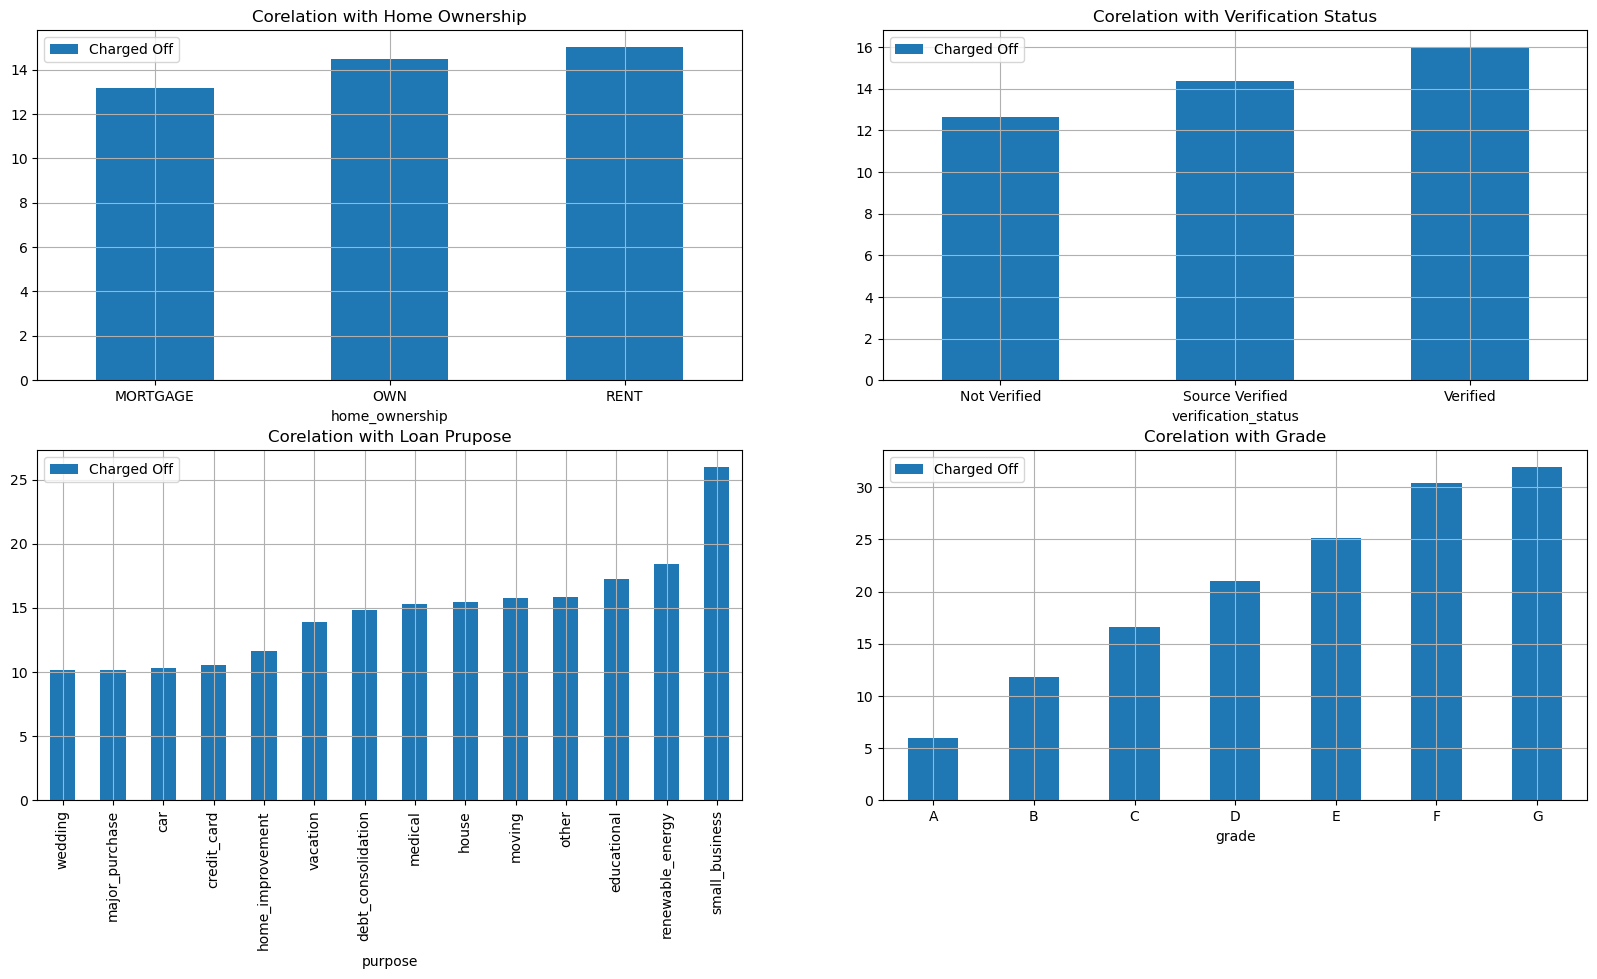

In [54]:
fig, axes = plt.subplots(2, 2,figsize=(20,10))
ax1 = final_df.groupby('home_ownership').loan_status.value_counts(normalize = True).unstack().T[['MORTGAGE','OWN','RENT']].T[-1].mul(100).to_frame('Charged Off').dropna().\
plot(kind = 'bar', grid = True, ax = axes[0,0], title = 'Corelation with Home Ownership')
for tick in ax1.get_xticklabels():
    tick.set_rotation(0)

ax2 = final_df.groupby('verification_status').loan_status.value_counts(normalize = True).unstack()[-1].mul(100).to_frame('Charged Off').dropna().\
plot(kind = 'bar', grid = True, ax = axes[0,1], title = 'Corelation with Verification Status')
for tick in ax2.get_xticklabels():
    tick.set_rotation(0)


ax3 = final_df.groupby('purpose').loan_status.value_counts(normalize = True).unstack()[-1].mul(100).to_frame('Charged Off').dropna().sort_values(by = 'Charged Off').\
plot(kind = 'bar', grid = True, ax = axes[1,0], title = 'Corelation with Loan Prupose')
for tick in ax3.get_xticklabels():
    tick.set_rotation(90)

ax4 = final_df.groupby('grade').loan_status.value_counts(normalize = True).unstack()[-1].mul(100).to_frame('Charged Off').dropna().\
plot(kind = 'bar', grid = True, ax = axes[1,1], title = 'Corelation with Grade')
for tick in ax4.get_xticklabels():
    tick.set_rotation(0)

In [57]:
df_for_cor = final_df.select_dtypes([float,int])

In [67]:
corr_matrix = df_for_cor.corr().round(2)

<Axes: >

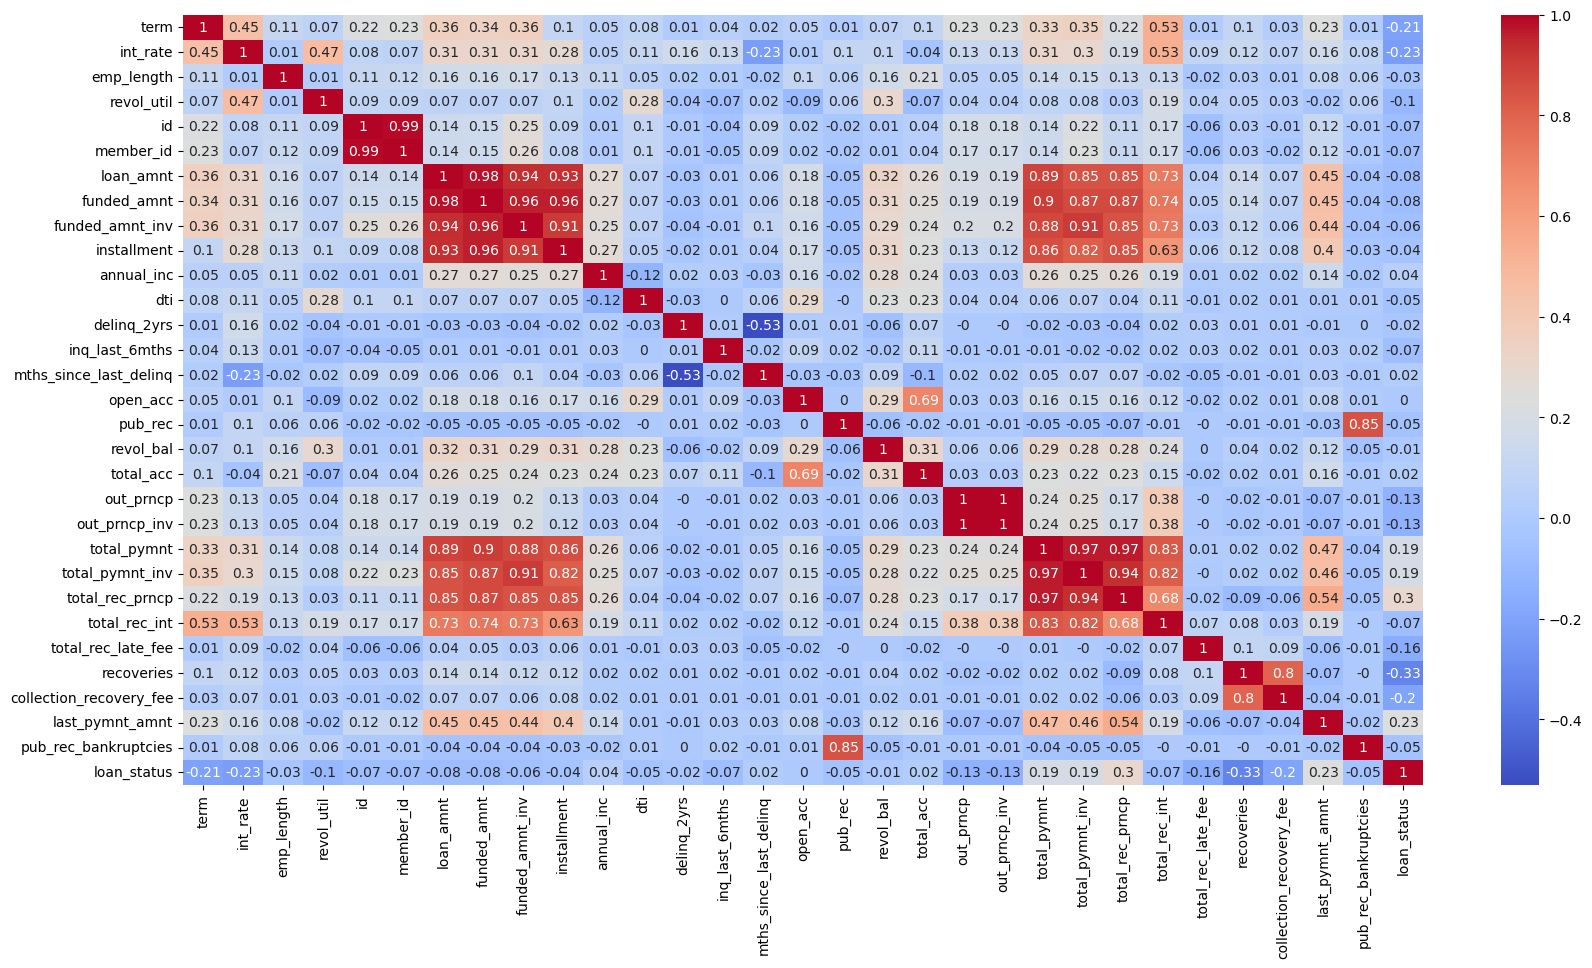

In [68]:
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')       